In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

complaints_df = pd.read_csv('../data/complaints.csv', delimiter=',')
complaints_df = complaints_df[['Consumer complaint narrative','Company','Company response to consumer']].copy()
complaints_df.columns = ['Narrative','Company', 'Response'] 
complaints_df.head()

,Narrative,Company,Response
0,I have complained many times that the credit r...,Experian Information Solutions Inc.,Closed with explanation
1,please review the current fraud account and al...,"Ideal Collection Services, Inc.",Closed with explanation
2,Called multiple times over the years for a deb...,"ONEMAIN FINANCIAL HOLDINGS, LLC.",Closed with explanation
3,I sent in a letter to the company to have them...,"Diversified Consultants, Inc.",Closed with explanation
4,On XX/XX/19 I applied for a Debt Relief Produc...,"ClearOne Advantage, LLC",Closed with explanation


Complaints worden gefilterd: enkel de 10 grootste bedrijven blijven over. Dit maakt het makkelijker om het aantal klachten per bedrijf te plotten, samen met de categorie van antwoord naar de klant toe.

In [2]:
complaints_df.replace({'Response': {'Closed': 'Closed without explanation'}}, inplace= True)
complaints_df = complaints_df[complaints_df['Response'].isin(['Closed with non-monetary relief',
                                                              'Closed with monetary relief', 'Closed with explanation',
                                                              'Closed without explanation', 'Untimely response'])]
counts = complaints_df.groupby('Company').count().reset_index()
biggest_companies = counts.sort_values(by='Response', ascending=False).head(10)['Company'].to_list()
print(biggest_companies)
complaints_filtered = complaints_df[complaints_df['Company'].isin(biggest_companies)]
response_counts = pd.DataFrame({'Count': complaints_filtered.groupby(['Company', 'Response']).size()})
response_counts.head(10)

['EQUIFAX, INC.', 'Experian Information Solutions Inc.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'WELLS FARGO & COMPANY', 'CITIBANK, N.A.', 'BANK OF AMERICA, NATIONAL ASSOCIATION', 'JPMORGAN CHASE & CO.', 'Navient Solutions, LLC.', 'CAPITAL ONE FINANCIAL CORPORATION', 'SYNCHRONY FINANCIAL']


Count
Company                               Response                              
BANK OF AMERICA, NATIONAL ASSOCIATION Closed with explanation          10579
                                      Closed with monetary relief       3639
                                      Closed with non-monetary relief   1392
                                      Closed without explanation          98
CAPITAL ONE FINANCIAL CORPORATION     Closed with explanation          10548
                                      Closed with monetary relief       1187
                                      Closed with non-monetary relief   1311
                                      Closed without explanation          10
CITIBANK, N.A.                        Closed with explanation          10928
                                      Closed with monetary relief       3198

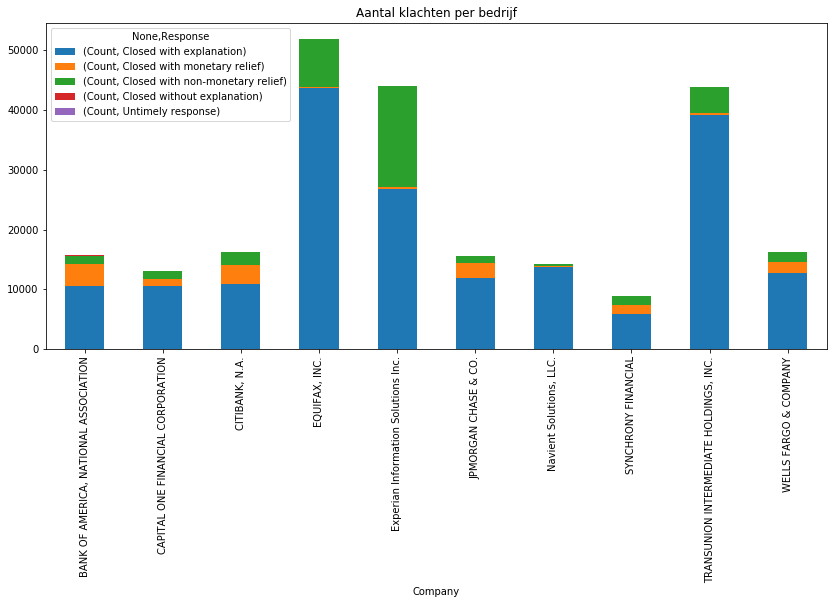

In [3]:
response_counts.unstack().plot(kind='bar', figsize=(14,6), stacked=True, title="Aantal klachten per bedrijf")

In [4]:
def sampling_k_elements(category, k=120000):
    if len(category) < k:
        return category
    return category.sample(k)

complaints_balanced_df = complaints_df.groupby('Response').apply(sampling_k_elements).reset_index(drop=True)

In [5]:
counts = complaints_balanced_df.groupby('Company').count().reset_index()
biggest_companies = counts.sort_values(by='Response', ascending=False).head(10)['Company'].to_list()
print(biggest_companies)
complaints_filtered = complaints_balanced_df[complaints_balanced_df['Company'].isin(biggest_companies)]
response_counts = pd.DataFrame({'Count': complaints_filtered.groupby(['Company', 'Response']).size()})
response_counts.head(10)

['Experian Information Solutions Inc.', 'EQUIFAX, INC.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'CITIBANK, N.A.', 'BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY', 'JPMORGAN CHASE & CO.', 'CAPITAL ONE FINANCIAL CORPORATION', 'SYNCHRONY FINANCIAL', 'Navient Solutions, LLC.']


Count
Company                               Response                              
BANK OF AMERICA, NATIONAL ASSOCIATION Closed with explanation           3263
                                      Closed with monetary relief       3639
                                      Closed with non-monetary relief   1392
                                      Closed without explanation          98
CAPITAL ONE FINANCIAL CORPORATION     Closed with explanation           3318
                                      Closed with monetary relief       1187
                                      Closed with non-monetary relief   1311
                                      Closed without explanation          10
CITIBANK, N.A.                        Closed with explanation           3270
                                      Closed with monetary relief       3198

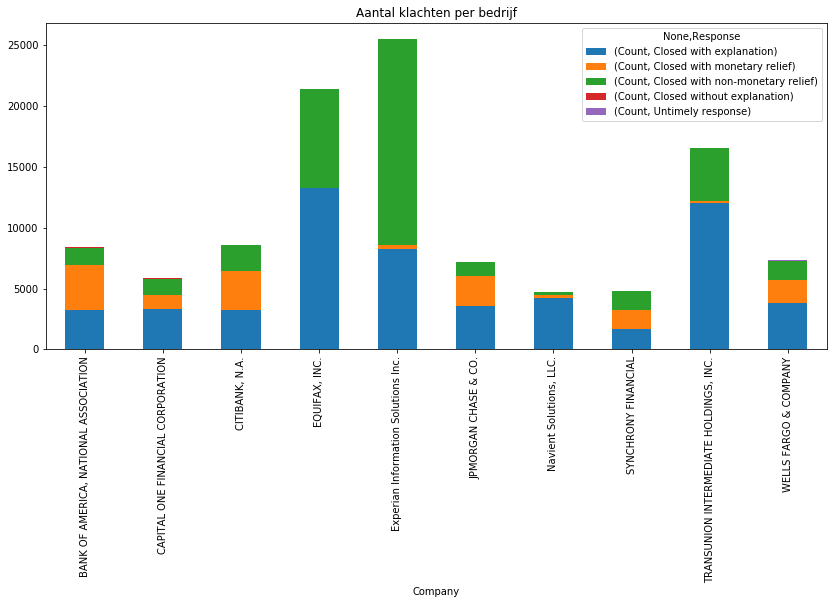

In [6]:
response_counts.unstack().plot(kind='bar', figsize=(14,6), stacked=True, title="Aantal klachten per bedrijf")

Nu worden aan de complaints dataframe kolommen toegevoegd die voor elke klacht de kans tonen dat een specifieke response gegeven wordt, op basis van het bedrijf waarnaar de klacht gestuurd is. Voor elk type response is er een kolom toegevoegd.

| Nummer  | Response |
| ------- | -------- |
| 1 | Closed with explanation |
| 2 | Closed with non-monetary relief |
| 3 | Closed with monetary relief |
| 4 | Closed without explanation |
| 5 | Untimely response |

In [7]:
#Aantal voorkomens van een bepaalde response tellen per bedrijf
c = pd.DataFrame({'Count': complaints_balanced_df.groupby(['Company', 'Response']).size()})
#Dit aantal omzetten in een percentage tegenover het aantal klachten per bedrijf
perc = c.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()),2)).reset_index()
#De responses pivoteren tot kolommen
gepivoteerd = perc.pivot_table('Count', ['Company'], 'Response')
#De kolommen opnieuw ordenen van meest naar minst voorkomend
gepivoteerd = gepivoteerd.reindex(['Closed with explanation', 'Closed with non-monetary relief', 'Closed with monetary relief',
                                   'Closed without explanation', 'Untimely response'], axis=1).reset_index()
#De complaints mergen met de percentages om een duidelijk overzicht te bekomen
merged_df = pd.merge(complaints_balanced_df, gepivoteerd, on='Company', how='inner')
merged_df = merged_df.fillna(0)
merged_df

,Narrative,Company,Response,Closed with explanation,Closed with non-monetary relief,Closed with monetary relief,Closed without explanation,Untimely response
0,i spoke to an agent from nationwide recovery s...,"Nationwide Recovery Systems, Ltd",Closed with explanation,100.0,0.0,0.0,0.0,0.0
1,Nationwide Recovery Sys Is in violation FDCA b...,"Nationwide Recovery Systems, Ltd",Closed with explanation,100.0,0.0,0.0,0.0,0.0
2,I received a notice regarding my trans union c...,"Nationwide Recovery Systems, Ltd",Closed with explanation,100.0,0.0,0.0,0.0,0.0
3,XXXX ACCOUNT NUMBERs : XXXX AND XXXX XXX...,"Nationwide Recovery Systems, Ltd",Closed with explanation,100.0,0.0,0.0,0.0,0.0
4,I was in a XXXX in XXXX of 2012. During my who...,"Nationwide Recovery Systems, Ltd",Closed with explanation,100.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
213141,This company has done a credit check on me. I ...,"COMPREHENSIVE LEGAL SOLUTIONS, INC.",Untimely response,0.0,0.0,0.0,0.0,100.0
213142,I was told that there was a septic tank after ...,"LIMESTONE TITLE AND ESCROW, LLC",Untimely response,0.0,0.0,0.0,0.0,100.0
213143,The XXXX XXXX XXXX XXXX called me because they...,"Gershfeld Law Group, P.C.",Untimely response,0.0,0.0,0.0,0.0,100.0
213144,In my review of my credit report XXXX XXXX is ...,"Concord Enterprises, LLC",Untimely response,0.0,0.0,0.0,0.0,100.0


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

feature_names = ['Closed with explanation', 'Closed with non-monetary relief', 'Closed with monetary relief',
                'Closed without explanation', 'Untimely response']
X = merged_df[feature_names]
y = merged_df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = SVC(gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

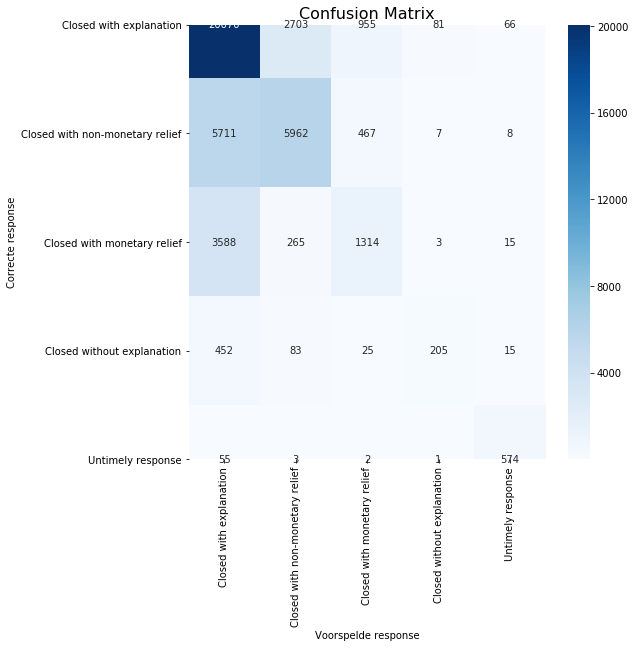

In [19]:
conf_mat = confusion_matrix(y_test, y_pred, labels=feature_names)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=feature_names, yticklabels=feature_names)
plt.ylabel('Correcte response')
plt.xlabel('Voorspelde response')
plt.title("Confusion Matrix", size=16);